In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import shifted_f, shifted_e, P_from_f, num_orbits, peri_advance_orbit, gen_wf, get_h, trim_wf, chirp2total, get_h, overlap_cplx_wfs, match_wfs, ceiltwo

# Generate training data

In [2]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
        
        h.resize(ceiltwo(len(h)))   
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [3]:
training_wfs = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 100, 4096, 'TEOBResumS')

100 done out of 100.

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


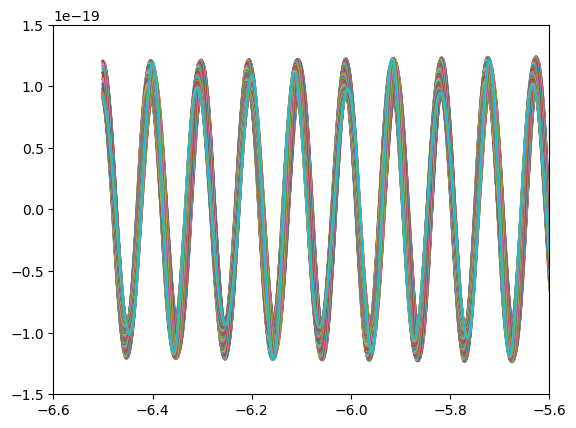

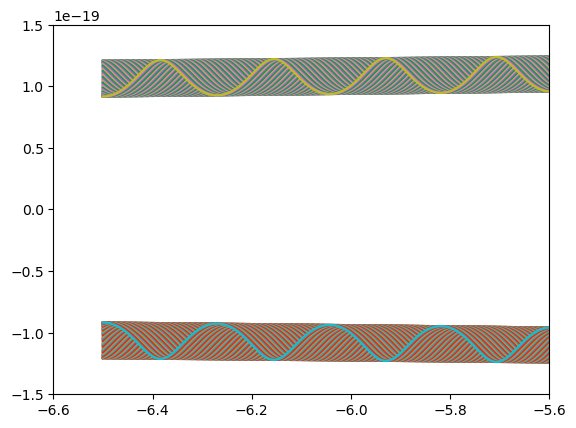

In [4]:
for wf in training_wfs:
    plt.plot(wf.sample_times, wf)
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

for wf in training_wfs:
    plt.plot(wf.sample_times, np.sqrt(wf.real()**2+wf.imag()**2))
    plt.plot(wf.sample_times, -np.sqrt(wf.real()**2+wf.imag()**2))
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

# Performing PCA

In [5]:
# Convert training wf data to np array in right shape/form and calc svd
start = time.time()
X = np.array(training_wfs).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U, S, Vh = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 630.9060187339783 seconds


# PCA results

In [6]:
pcs = Vh

Relative importance of ith direction is given by:

\begin{equation}
\frac{S_i^2}{\Sigma_i S_i^2}
\end{equation}

Coefficients of xth waveform for each direction are given by pcs.T[x]. All of the coefficents in the yth direction are therefore given by pcs[y]. Every component is complex and thus has both a real and imaginary part.

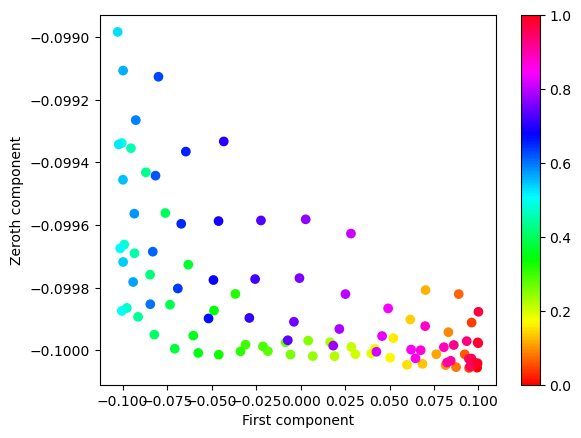

In [7]:
# Plot of real parts of zeroth, first directions
colors = np.linspace(0,1,100,endpoint=False)
plt.scatter(np.real(pcs[1]), np.real(pcs[0]), c=colors, vmin=0, vmax=1, cmap='hsv')
plt.xlabel('First component')
plt.ylabel('Zeroth component')
plt.colorbar()

See that real part of zeroth component is always very close to -0.1. Turns out imaginary part is also always v. close to 0. Real part of first component is positive for h_peri (i.e. opposite to zeroth component), and negative for h_ap (i.e. opposite to first component). This is consistent with our current picture of zeroth/first components being h1/h2, as h_peri = h_1 - h_2 and h_ap = h_1 + h_2. Overall negative sign above is arbitrary and can be switched by simply changing phase by pi.

Now plot complex values of first component only (as zeroth component seems to be almost exactly -0.1+0j by construction).

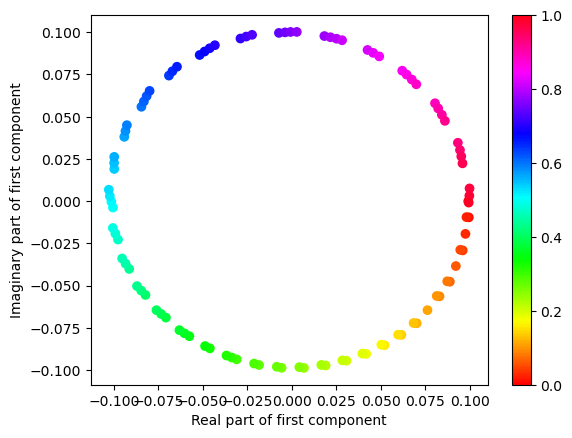

In [8]:
# Plot of complex parts of first direction
colors = np.linspace(0,1,100,endpoint=False)
plt.scatter(np.real(pcs[1]), np.imag(pcs[1]), c=colors, vmin=0, vmax=1, cmap='hsv')
plt.xlabel('Real part of first component')
plt.ylabel('Imaginary part of first component')
plt.colorbar()

Can very clearly see that as true anomaly is changed over 2pi, the first component rotates around a complete circle in complex space.

Now look at S matrix to check relative importance of each component.

In [9]:
rel_imports = []
for i in range(10):
    rel_imports.append(S[i]**2/np.sum(S**2))
    print('Component {} contains {:.5f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Components 0 and 1 combined contain {:.5f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Component 0 contains 96.72895% of the total information.
Component 1 contains 2.60452% of the total information.
Component 2 contains 0.59432% of the total information.
Component 3 contains 0.05274% of the total information.
Component 4 contains 0.01821% of the total information.
Component 5 contains 0.00097% of the total information.
Component 6 contains 0.00018% of the total information.
Component 7 contains 0.00005% of the total information.
Component 8 contains 0.00004% of the total information.
Component 9 contains 0.00002% of the total information.


Components 0 and 1 combined contain 99.33347% of the total information.


Can see that for $e_{10} = 0.1$, $\mathcal{M} = 24 M_\odot$, $q=2$, the first two components alone contain 99.3% of the total information. The model therefore seems to be quite a good approximation in this region of parameter space. By repeating this for different parameter choices, we could see in which regions this model would break down.

The first two components here are consistent with being h1 and h2 respectively, however this is not proven to be the case. In order to prove these, should plot combinations of h1 and h2 using these coefficients and check against original waveforms.

# h1, h2 comparison

In [10]:
# Plots and compares match between training waveform and combination of h1 and h2 waveforms
def compare_wfs(training_wf, h1_h2_comps, f_low, e, M, q, sample_rate, approximant):

    # Generate h from h1, h2 components
    h, _, _, _, _ = get_h(h1_h2_comps, f_low, e, M, q, sample_rate, approximant=approximant)

    # Calculate match between waveforms
    m = match_wfs(training_wf, h, 10, True)
    print(f'Match of {np.abs(m)}')

    # Plot both real waveforms
    plt.plot(training_wf.sample_times, training_wf.real(), label='Training wf')
    plt.plot(h.sample_times, h.real(), label='From h1, h2 components')
    plt.title('Real')
    plt.xlim(-7,-5)
    plt.legend() 
    plt.show()

    # Plot both imaginary waveforms
    plt.plot(training_wf.sample_times, training_wf.imag(), label='Training wf')
    plt.plot(h.sample_times, h.imag(), label='From h1, h2 components')
    plt.title('Imaginary')
    plt.xlim(-7,-5)
    plt.legend()
    plt.show()

    # Plot both waveform envelopes
    plt.plot(training_wf.sample_times, np.sqrt(training_wf.real()**2+training_wf.imag()**2), c='C0', label='Training wf')
    plt.plot(training_wf.sample_times, -np.sqrt(training_wf.real()**2+training_wf.imag()**2), c='C0')
    plt.plot(h.sample_times, np.sqrt(h.real()**2+h.imag()**2), c='C1', label='From h1, h2 components')
    plt.plot(h.sample_times, -np.sqrt(h.real()**2+h.imag()**2), c='C1')
    plt.title('Envelopes')
    plt.xlim(-7,-5)
    plt.legend()
    plt.show()

First plot h_ap training waveform (i.e. the first training waveform), and use the h1, h2 components from the pca/svd above. Will multiply these components by (-10,10) first in order to get roughly same scale (and right sign). Can do this as match function does not care about amplitude or phase. Can multiple each component by opposite sign as can choose/postulate that directions from pca/svd actually correspond to e.g. -h1, +h2.

[(1.0005508626908255-0j), (0.9925419636326263+0j)]
1.9930928263234517
Match of 0.9993458243884433


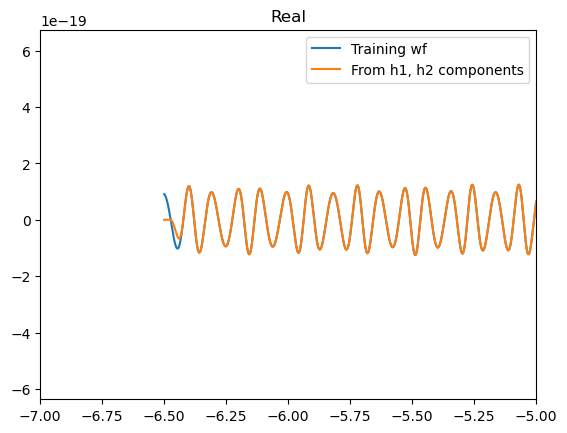

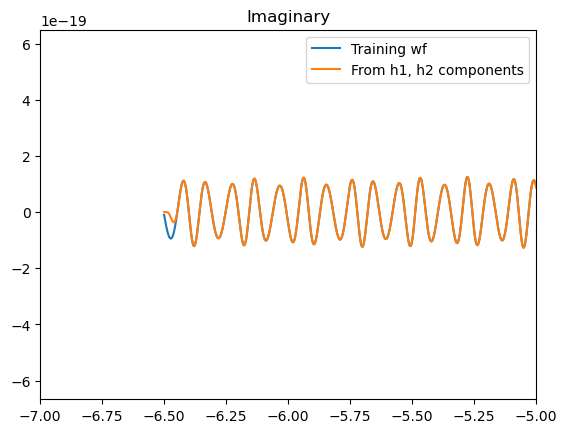

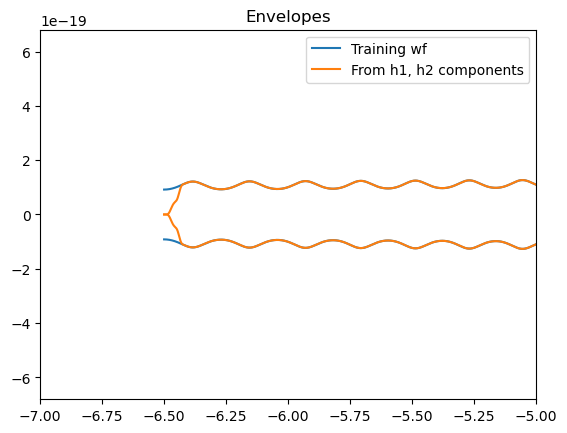

In [11]:
components = [-10*pcs[0][0], 10*pcs[1][0]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[0], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

Looks very good! Now try for h_peri (50th training waveform), as well as a few others.

[(0.9987405170319408+0.04905618092918878j), (-1.0048036088968566-0.038091819120620894j)]
2.005469937772993
Match of 0.9987597483169843


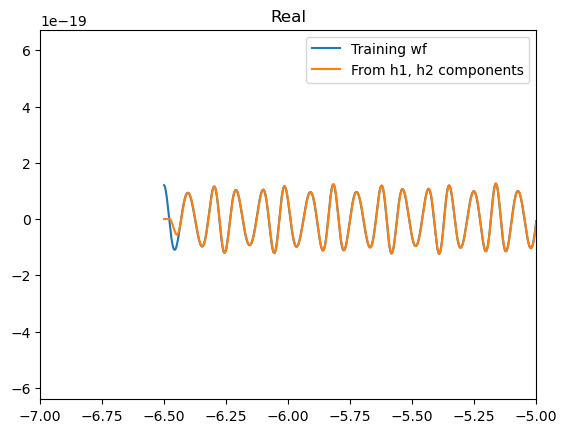

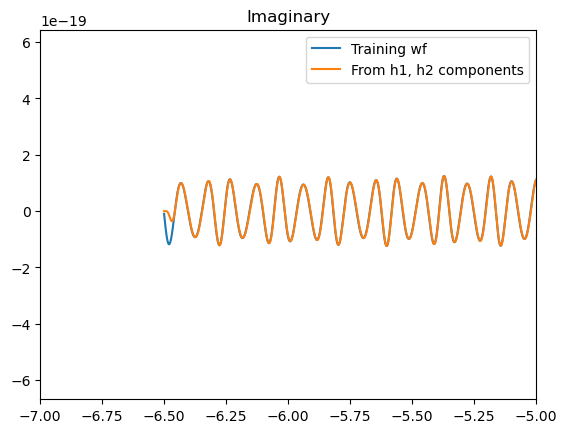

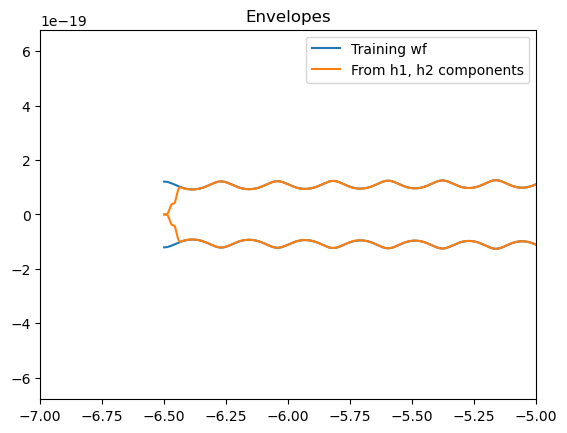

In [12]:
components = [-10*pcs[0][50], 10*pcs[1][50]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[50], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

[(0.9996877542003013+0.03769320852523642j), (0.04296946211711247-0.983366348361284j)]
1.9847028164059801
Match of 0.996776193401566


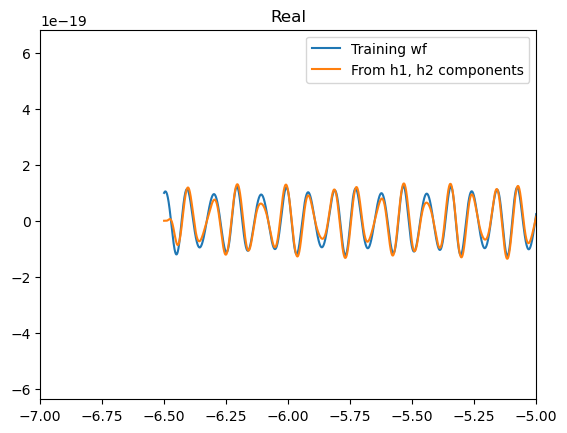

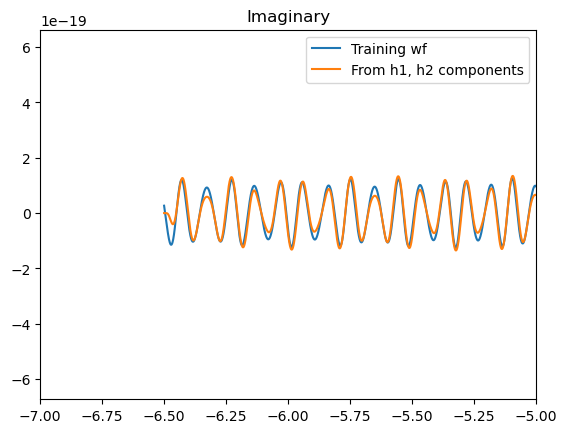

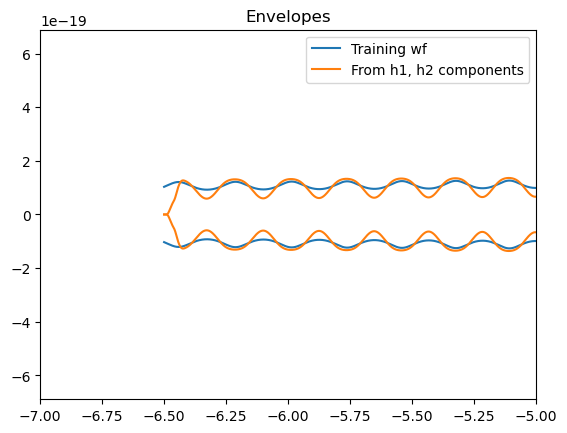

In [13]:
components = [-10*pcs[0][25], 10*pcs[1][25]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[25], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

This is possibly where the 0.7% of information lost by keeping only the first two components comes into play.

# Proper h1, h2 comparison

In above section we simply combined our own h1 and h2 waveforms using the outputted components (V matrix) of the SVD. Here we will instead use the (first two) U matrix components to examine the waveforms used by the SVD as its equivalent to out own h1 and h2.

First, plot the first two waveforms in U and compare to h1, h2. Will apply (arbitrary) scaling/sign to compare them easier.

In [14]:
# h1, h2 waveforms for comparison
_, h1, h2, h_ap, h_peri = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)

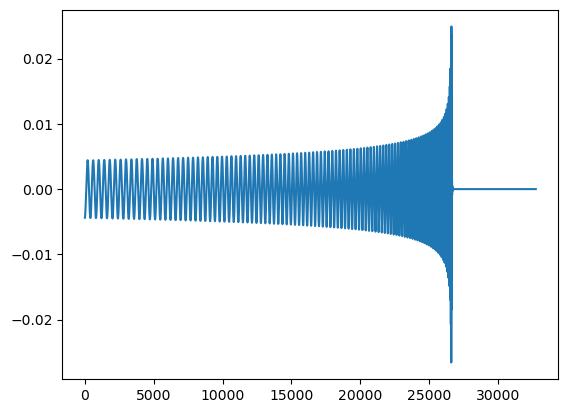

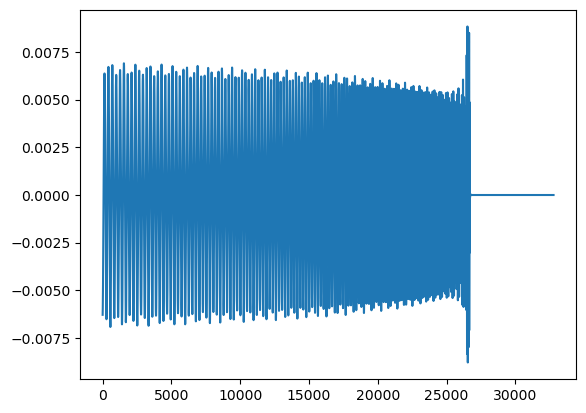

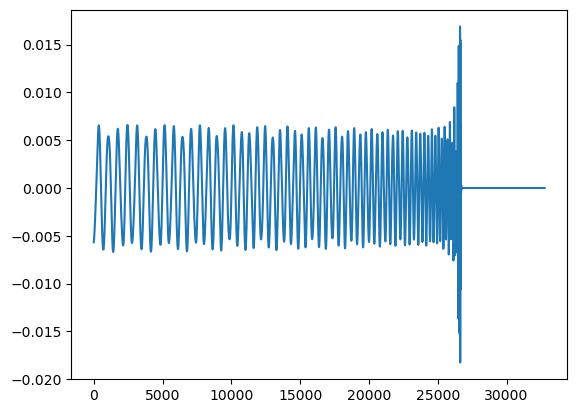

In [15]:
# Plot first two waveforms in U to see shape
plt.plot(np.arange(len(U.T[0])), U.T[0])
plt.show()
plt.plot(np.arange(len(U.T[1])), U.T[1])
plt.show()
plt.plot(np.arange(len(U.T[2])), U.T[2])


See very similar patterns here to our h1 and h2 waveforms. The first looks like a non-eccentric waveform with the second containing the (dominant) eccentric correction. Will now overplot our h1, h2 waveforms.

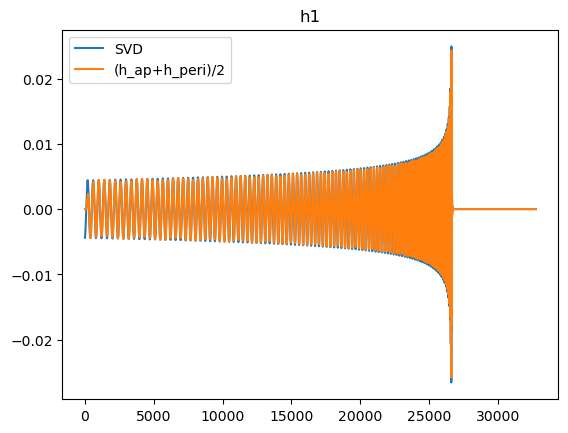

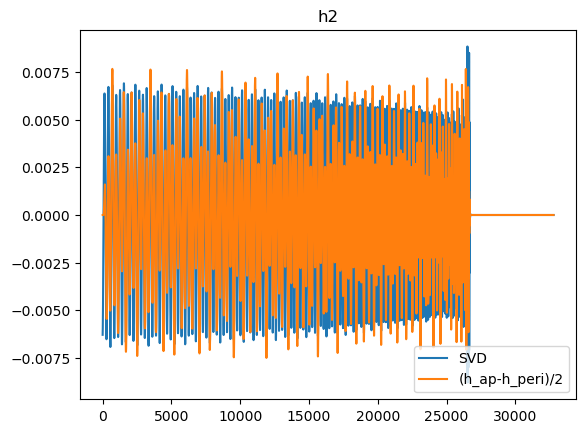

In [16]:
scale_1 = -4.2*10**16
scale_2 = 2*10**17

# Compare first two waveforms in U to our h1, h2 waveforms
plt.plot(np.arange(len(U.T[0])), U.T[0], label='SVD')
plt.plot(np.arange(len(h1)), h1*scale_1, label='(h_ap+h_peri)/2')
plt.title('h1')
plt.legend()
plt.show()
plt.plot(np.arange(len(U.T[1])), U.T[1], label='SVD')
plt.plot(np.arange(len(h2)), h2*scale_2, label='(h_ap-h_peri)/2')
plt.title('h2')
plt.legend()
plt.show()

And 'zoomed' versions below focusing on just a few cycles.

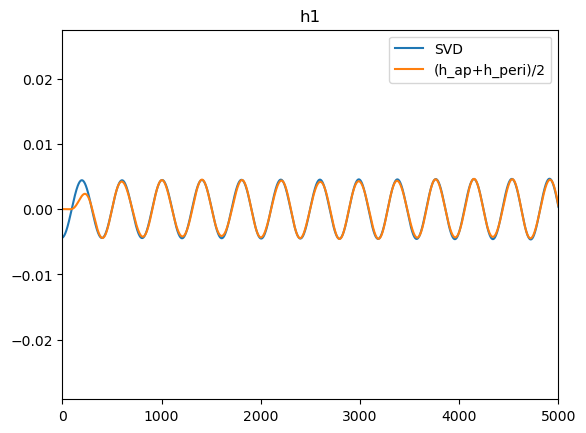

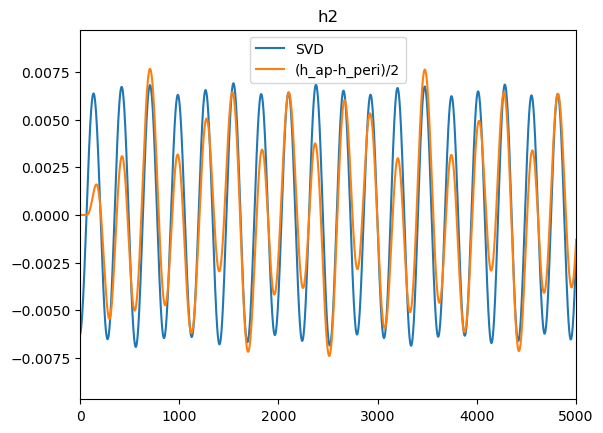

In [17]:
# Zoom in to comparison plot
plt.plot(np.arange(len(U.T[0])), U.T[0], label='SVD')
plt.plot(np.arange(len(h1)), h1*scale_1, label='(h_ap+h_peri)/2')
plt.title('h1')
plt.xlim(0,5000)
plt.legend()
plt.show()
plt.plot(np.arange(len(U.T[1])), U.T[1], label='SVD')
plt.plot(np.arange(len(h2)), h2*scale_2, label='(h_ap-h_peri)/2')
plt.title('h2')
plt.xlim(0,5000)
plt.legend()
plt.show()

h1 from the SVD looks very similar to our own, with the only visible difference being that ours still seems to contain a (slight) trace of eccentricity. h2 differs much more, with the eccentricity variations being much larger in our version compared to that from the S

(0.0, 20000.0)

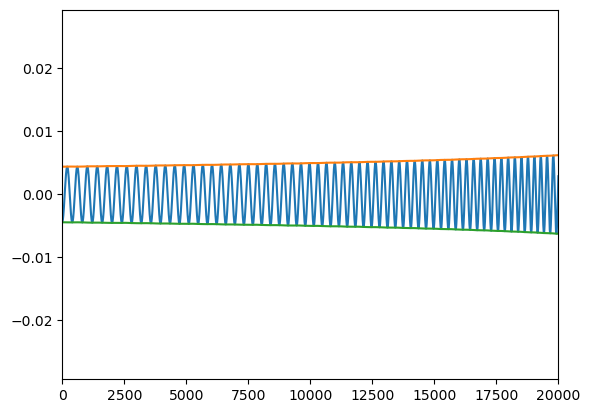

In [18]:
plt.plot(np.arange(len(U.T[0])), U.T[0])
plt.plot(np.arange(len(U.T[0])), np.sqrt(np.real(U.T[0])**2+np.imag(U.T[0])**2))
plt.plot(np.arange(len(U.T[0])), -np.sqrt(np.real(U.T[0])**2+np.imag(U.T[0])**2))
plt.xlim(0,20000)

(0.0, 20000.0)

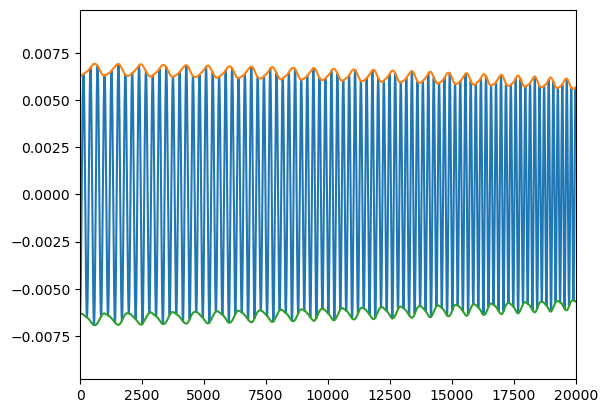

In [19]:
plt.plot(np.arange(len(U.T[1])), U.T[1])
plt.plot(np.arange(len(U.T[1])), np.sqrt(np.real(U.T[1])**2+np.imag(U.T[1])**2))
plt.plot(np.arange(len(U.T[1])), -np.sqrt(np.real(U.T[1])**2+np.imag(U.T[1])**2))
plt.xlim(0,20000)

(0.0, 20000.0)

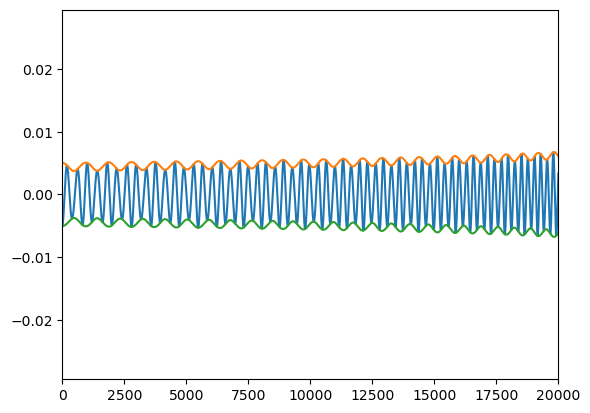

In [20]:
a = U.T[0]+0.1*U.T[1]
plt.plot(np.arange(len(a)), a)
plt.plot(np.arange(len(a)), np.sqrt(np.real(a)**2+np.imag(a)**2))
plt.plot(np.arange(len(a)), -np.sqrt(np.real(a)**2+np.imag(a)**2))
plt.xlim(0,20000)

Envelope of the second SVD waveform shows modulations which are not symmetric oscillations. When added to the first waveform (which has increasing enevelope with no oscillations) however, these oscillations become 'symmetric' as one expects from a physical system, and the resulting waveform looks very similar to a TEOBResumS waveform (see e.g. below for h_ap).

(0.0, 20000.0)

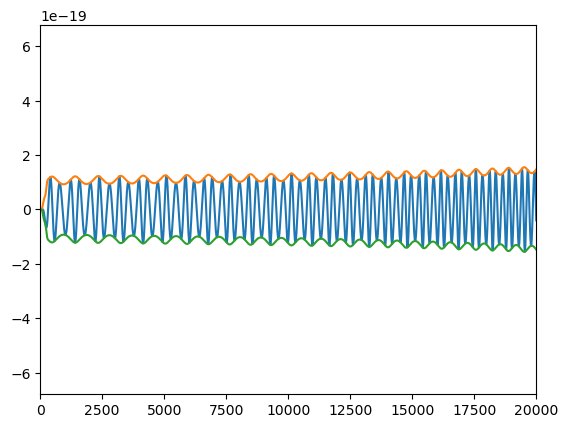

In [21]:
a = np.array(h_ap)
plt.plot(np.arange(len(a)), a)
plt.plot(np.arange(len(a)), np.sqrt(np.real(a)**2+np.imag(a)**2))
plt.plot(np.arange(len(a)), -np.sqrt(np.real(a)**2+np.imag(a)**2))
plt.xlim(0,20000)

# Reconstructing training waveforms

Here we will multiply the SVD waveforms through S and V* to reconstruct the training waveforms using only the two most important waveform components.

In [22]:
# Reconstruct training waveforms from first two SVD waveforms and corresponding coefficients
trunc_U = np.array([U.T[0], U.T[1]]).T
trunc_S = np.diag(S[:2])
trunc_Vh = np.array([pcs[0], pcs[1]])
reconstructed_wfs = (np.matmul(trunc_U, np.matmul(trunc_S, trunc_Vh))*stds).T
pad_zeros = ceiltwo(len(reconstructed_wfs[0]))- len(reconstructed_wfs[0])
re_wfs = np.pad(reconstructed_wfs, ((0,0),(0,pad_zeros)))

(-6.0, -4.0)

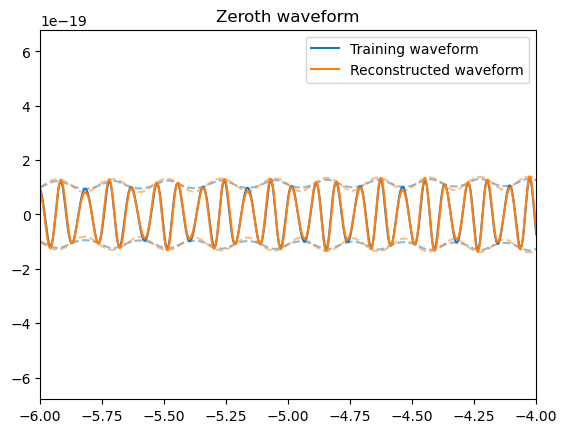

In [23]:
# Compare reconstructed to original waveform
plt.plot(training_wfs[0].sample_times, training_wfs[0], c='C0', label='Training waveform')
plt.plot(training_wfs[0].sample_times, np.sqrt(training_wfs[0].real()**2+training_wfs[0].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[0].sample_times, -np.sqrt(training_wfs[0].real()**2+training_wfs[0].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[0].sample_times, re_wfs[0], c='C1', label='Reconstructed waveform')
plt.plot(training_wfs[0].sample_times, np.sqrt(np.real(re_wfs[0])**2+np.imag(re_wfs[0])**2), c='C1', ls='dashed', alpha=0.5)
plt.plot(training_wfs[0].sample_times, -np.sqrt(np.real(re_wfs[0])**2+np.imag(re_wfs[0])**2), c='C1', ls='dashed', alpha=0.5)
plt.legend()
plt.title('Zeroth waveform')
plt.xlim(-6,-4)

(-6.0, -4.0)

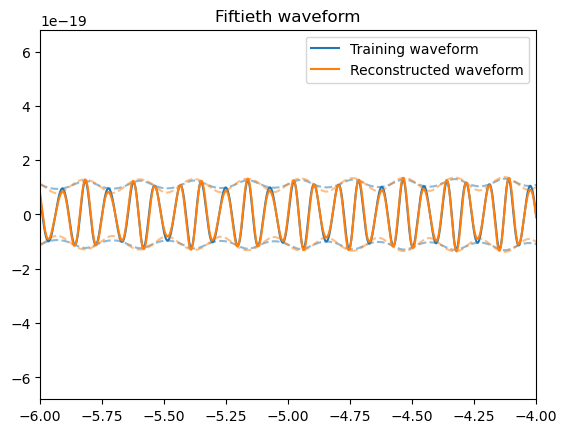

In [24]:
# Compare reconstructed to original waveform
plt.plot(training_wfs[50].sample_times, training_wfs[50], c='C0', label='Training waveform')
plt.plot(training_wfs[50].sample_times, np.sqrt(training_wfs[50].real()**2+training_wfs[50].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[50].sample_times, -np.sqrt(training_wfs[50].real()**2+training_wfs[50].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[50].sample_times, re_wfs[50], c='C1', label='Reconstructed waveform')
plt.plot(training_wfs[50].sample_times, np.sqrt(np.real(re_wfs[50])**2+np.imag(re_wfs[50])**2), c='C1', ls='dashed', alpha=0.5)
plt.plot(training_wfs[50].sample_times, -np.sqrt(np.real(re_wfs[50])**2+np.imag(re_wfs[50])**2), c='C1', ls='dashed', alpha=0.5)
plt.legend()
plt.title('Fiftieth waveform')
plt.xlim(-6,-4)

(-6.0, -4.0)

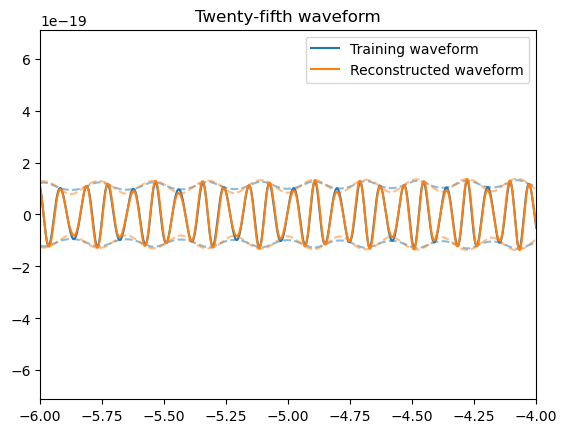

In [25]:
# Compare reconstructed to original waveform
plt.plot(training_wfs[25].sample_times, training_wfs[25], c='C0', label='Training waveform')
plt.plot(training_wfs[25].sample_times, np.sqrt(training_wfs[25].real()**2+training_wfs[25].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[25].sample_times, -np.sqrt(training_wfs[25].real()**2+training_wfs[25].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[25].sample_times, re_wfs[25], c='C1', label='Reconstructed waveform')
plt.plot(training_wfs[25].sample_times, np.sqrt(np.real(re_wfs[25])**2+np.imag(re_wfs[25])**2), c='C1', ls='dashed', alpha=0.5)
plt.plot(training_wfs[25].sample_times, -np.sqrt(np.real(re_wfs[25])**2+np.imag(re_wfs[25])**2), c='C1', ls='dashed', alpha=0.5)
plt.legend()
plt.title('Twenty-fifth waveform')
plt.xlim(-6,-4)

(-6.0, -4.0)

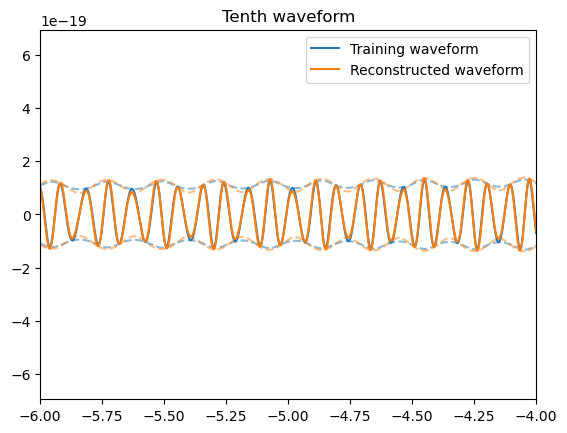

In [26]:
# Compare reconstructed to original waveform
plt.plot(training_wfs[10].sample_times, training_wfs[10], c='C0', label='Training waveform')
plt.plot(training_wfs[10].sample_times, np.sqrt(training_wfs[10].real()**2+training_wfs[10].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[10].sample_times, -np.sqrt(training_wfs[10].real()**2+training_wfs[10].imag()**2), c='C0', ls='dashed', alpha=0.5)
plt.plot(training_wfs[10].sample_times, re_wfs[10], c='C1', label='Reconstructed waveform')
plt.plot(training_wfs[10].sample_times, np.sqrt(np.real(re_wfs[10])**2+np.imag(re_wfs[10])**2), c='C1', ls='dashed', alpha=0.5)
plt.plot(training_wfs[10].sample_times, -np.sqrt(np.real(re_wfs[10])**2+np.imag(re_wfs[10])**2), c='C1', ls='dashed', alpha=0.5)
plt.legend()
plt.title('Tenth waveform')
plt.xlim(-6,-4)

# Save SVD waveforms

In [27]:
# Save U matrix containing SVD waveforms to use elsewhere
def save_SVD_wfs(name, U_matrix):
    with open(os.path.join('SVD_waveforms', name), 'wb') as fp:
        pickle.dump(U_matrix, fp)

In [28]:
#save_SVD_wfs('U_matrix_2svd_100t.pkl', [U.T[0], U.T[1]])

# Solving for U

Want to solve $T=USV^*$ for U such that we can find the svd waveforms in terms of coefficients of the training waveforms.

\begin{equation}
T = USV^*
\end{equation}

\begin{equation}
U = T(V^*)^{-1}S^{-1}
\end{equation}

\begin{equation}
U = TVS^{-1}
\end{equation}

Where we have used that V is a complex unitary matrix, so $V^* = V^{-1}$. Additionally, S is simply a (rectangular) diagonal matrix, so its inverse is trivial to calculate.

Both the U and T matrices can be considered as a row vectors with each element being the appropriate waveform. Therefore the coefficients of the training waveforms which compose each svd waveform are simply the columns of $VS^{-1}$. We also do not need the full rectangular part of $S^{-1}$ as the non-square part is all zeros, and simply describes the coefficients for the 101st SVD waveform onwards, which we are not interested in.

In [29]:
# Inverse of Vh (i.e. hermitian matrix)
V = Vh.T.conj()

# Inverse of S
inv_S = 1/S

# Multiply together
Vinv_S = np.matmul(V, np.diag(inv_S))

Test that the columns do indeed describe the svd waveforms in terms of the training waveforms:

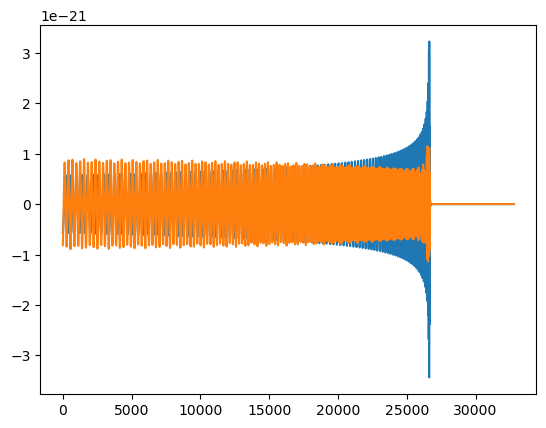

In [30]:
a = np.matmul(np.array(training_wfs).T, Vinv_S.T[0])
b = np.matmul(np.array(training_wfs).T, Vinv_S.T[1])
plt.plot(np.arange(len(a)), a)
plt.plot(np.arange(len(b)), b)

These are indeed the first two svd waveforms, as desired!

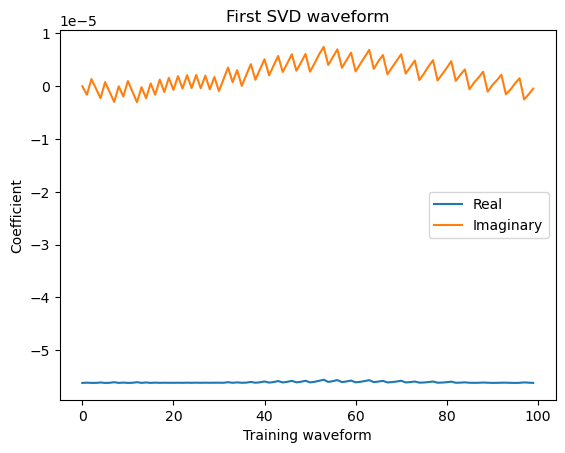

In [31]:
plt.plot(np.arange(len(Vinv_S.T[0])), np.real(Vinv_S.T[0]), label='Real')
plt.plot(np.arange(len(Vinv_S.T[0])), np.imag(Vinv_S.T[0]), label='Imaginary')
plt.title('First SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()

It seems that the first SVD waveform is simply made up of a simple average of all the training waveforms, shown by the coefficient above being approximately constant across all training waveforms. This matches the natural expansion of our h1 to higher number of waveform components. Now repeat for the second SVD waveform.

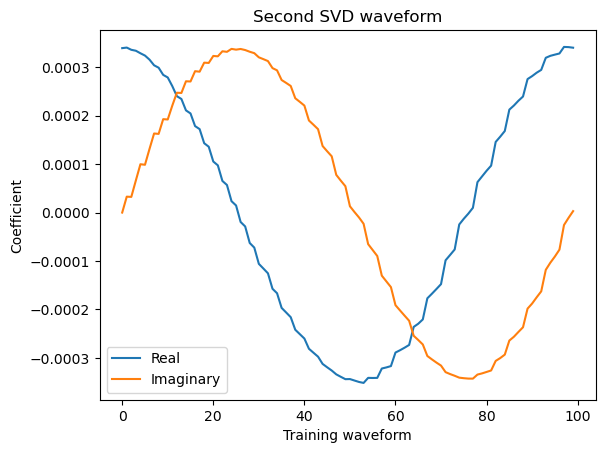

In [32]:
plt.plot(np.arange(len(Vinv_S.T[1])), np.real(Vinv_S.T[1]), label='Real')
plt.plot(np.arange(len(Vinv_S.T[1])), np.imag(Vinv_S.T[1]), label='Imaginary')
plt.title('Second SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()

This also perhaps matches what we would expect, and certainly just looking at the first and fifty-first training waveforms (corresponding to h_ap and h_peri), we see that this would indeed give our expression of $h_2 = (h_{ap} - h_{peri})/2$. Both the real and imaginary coefficients of training waveforms here follow a clear sinusoidal pattern, allowing simple extrapolation to higher numbers of component waveforms. 

Explicitly, for $n$ waveform components labelled $s_1, \ldots, s_n$ this means that $h_2$ should be defined as $h_2 = z_1 s_1 + \ldots + z_n s_n$, where $\{z_1, \ldots, z_n\}$ are the solutions to $z^n = 1$, i.e. the $n$th roots of unity.

For completeness, the training waveforms coefficients of higher SVD waveforms are also shown below:

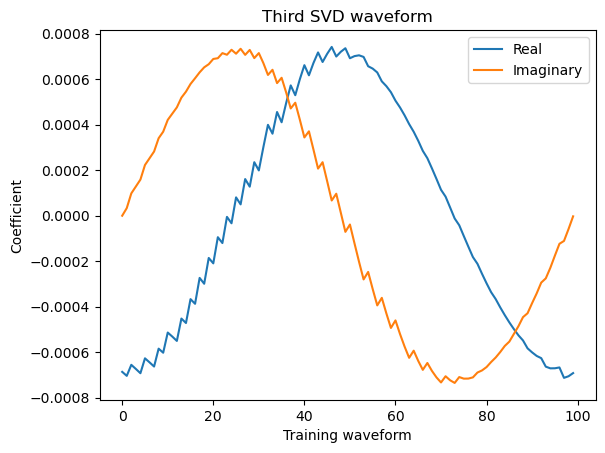

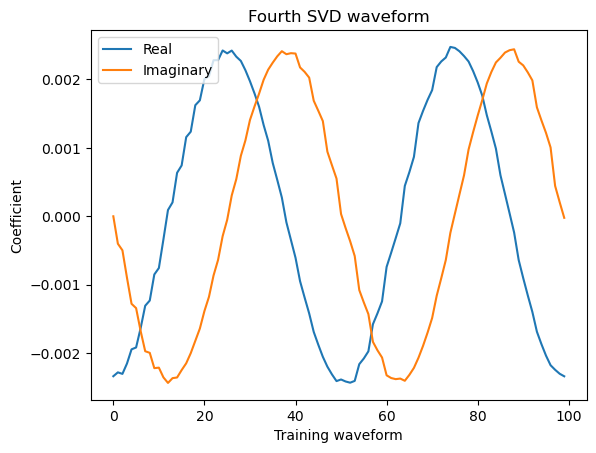

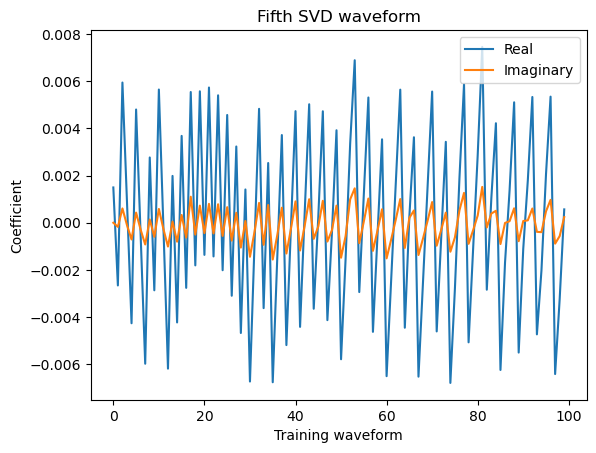

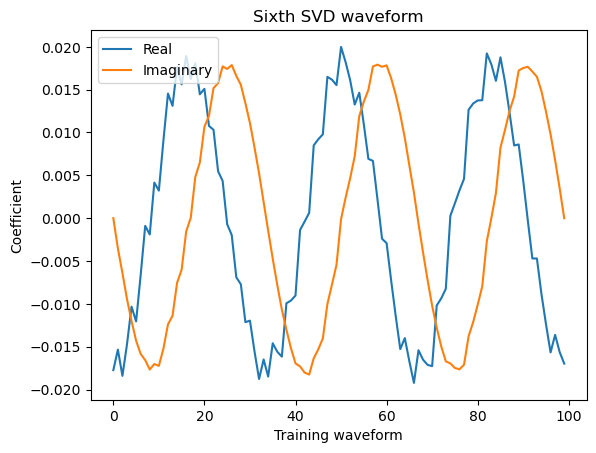

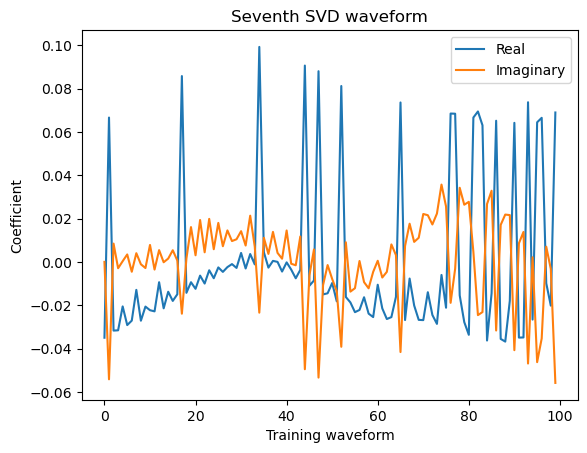

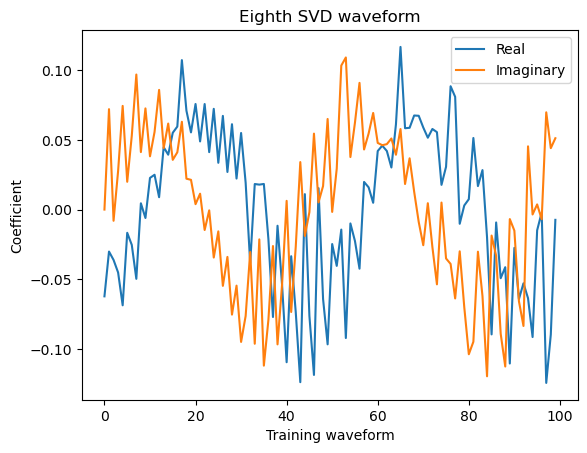

In [33]:
names = ['Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth']

for i, name in enumerate(names):
    plt.plot(np.arange(len(Vinv_S.T[i+2])), np.real(Vinv_S.T[i+2]), label='Real')
    plt.plot(np.arange(len(Vinv_S.T[i+2])), np.imag(Vinv_S.T[i+2]), label='Imaginary')
    plt.title(f'{name} SVD waveform')
    plt.xlabel('Training waveform')
    plt.ylabel('Coefficient')
    plt.legend()
    plt.show()

The pattern in the fifth and higher SVD waveforms appear to break down (with the exception of the sixth). This should not be too surprising as the $S$ matrix suggests that the first four SVD waveforms alone account for 99.98% of the total information.

# SVD on smaller training sets

Will now perform SVD on training sets of two, three, and four waveforms to check that the predicitons made above for how h1 and h2 should be calculated do indeed scale down from 100 to (more realistic for our case) small numbers.

In [34]:
# Generate training waveform sets
training_wfs_2 = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 2, 4096, 'TEOBResumS')
training_wfs_3 = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 3, 4096, 'TEOBResumS')
training_wfs_4 = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 4, 4096, 'TEOBResumS')

4 done out of 4.

In [35]:
# Perform SVD on two training waveforms
start = time.time()
X = np.array(training_wfs_2).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_2, S_2, Vh_2 = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

# Perform SVD on three training waveforms
start = time.time()
X = np.array(training_wfs_3).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_3, S_3, Vh_3 = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

# Perform SVD on four training waveforms
start = time.time()
X = np.array(training_wfs_4).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_4, S_4, Vh_4 = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 94.13411831855774 seconds
Time taken: 111.40234303474426 seconds
Time taken: 152.10924530029297 seconds


(0.0035, 0.008)

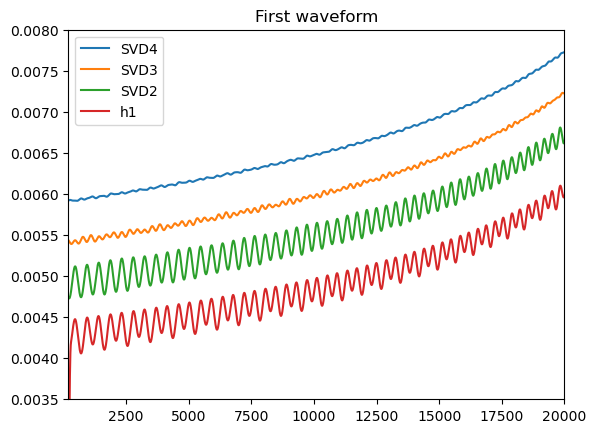

In [36]:
plt.plot(np.arange(len(U_2.T[0])), np.sqrt(np.real(U_4.T[0])**2+np.imag(U_4.T[0])**2)+0.0015, label='SVD4')
plt.plot(np.arange(len(U_2.T[0])), np.sqrt(np.real(U_3.T[0])**2+np.imag(U_3.T[0])**2)+0.001, label='SVD3')
plt.plot(np.arange(len(U_2.T[0])), np.sqrt(np.real(U_2.T[0])**2+np.imag(U_2.T[0])**2)+0.0005, label='SVD2')
plt.plot(np.arange(len(U_2.T[0])), np.sqrt(h1.real()**2+h1.imag()**2)*-scale_1, label='h1')
plt.legend()
plt.title('First waveform')
plt.xlim(200,20000)
plt.ylim(0.0035,0.008)

Can see for these 'h1-like' waveforms that the envelopes plotted here have less wiggles the more training waveforms are used (as expected). Additionally, the magnitude of the wiggles is consistent between the SVD with 2 training waveforms and our h1, which also uses two component waveforms. Note have shifted lines up away from each other here to differentiate them - ignore y axis scale.

Now repeat for second waveform to see improvements with more waveform components

(0.0, 5000.0)

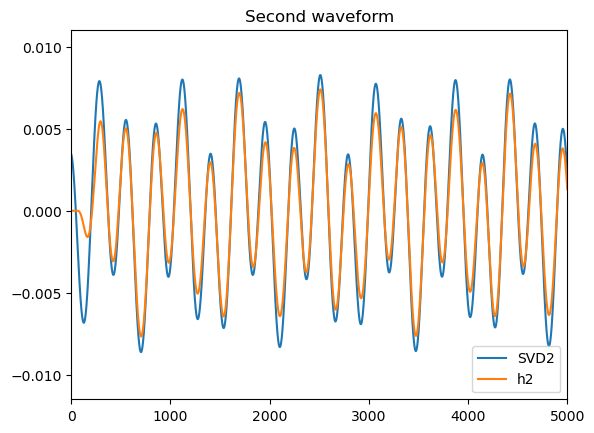

In [37]:
plt.plot(np.arange(len(U_2.T[1])), U_2.T[1], label='SVD2')
plt.plot(np.arange(len(U_2.T[1])), h2*-scale_2, label='h2')
plt.legend()
plt.title('Second waveform')
plt.xlim(0,5000)

Can see that again h2 and SVD2 are near-identical (remember scaling in y direction is arbitrary).

(0.0, 5000.0)

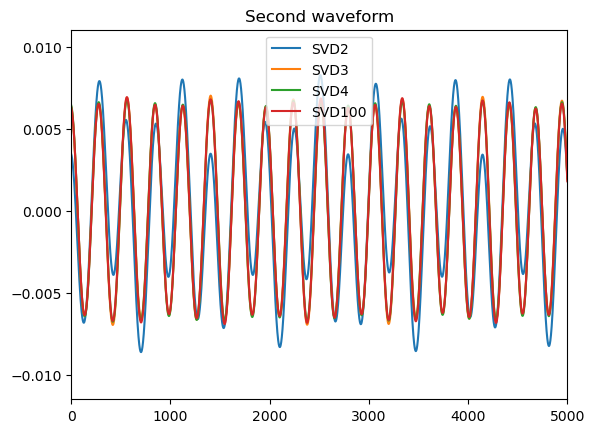

In [38]:
plt.plot(np.arange(len(U_2.T[1])), U_2.T[1], label='SVD2')
plt.plot(np.arange(len(U_2.T[1])), U_3.T[1], label='SVD3')
plt.plot(np.arange(len(U_2.T[1])), U_4.T[1], label='SVD4')
plt.plot(np.arange(len(U_2.T[1])), -U.T[1], label='SVD100')
plt.legend()
plt.title('Second waveform')
plt.xlim(0,5000)

All agree very well, apart from SVD2. Clearly the third waveform component is important to describe h2 well.

(0.0, 5000.0)

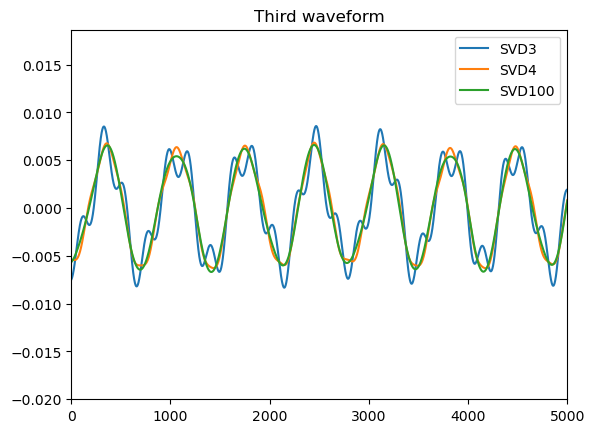

In [39]:
plt.plot(np.arange(len(U_3.T[2])), -U_3.T[2], label='SVD3')
plt.plot(np.arange(len(U_3.T[2])), U_4.T[2], label='SVD4')
plt.plot(np.arange(len(U_3.T[2])), U.T[2], label='SVD100')
plt.legend()
plt.title('Third waveform')
plt.xlim(0,5000)

Again here SVD3 struggles to describe 'h3' well without a fourth waveform component. It appears that n+1 waveform components are required to accurately describe $h_n$. If this is true, should see that SVD4 struggles to describe $h_4$ well compared to SVD100.

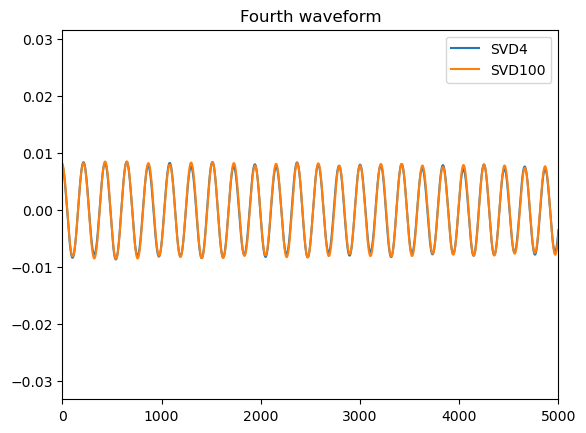

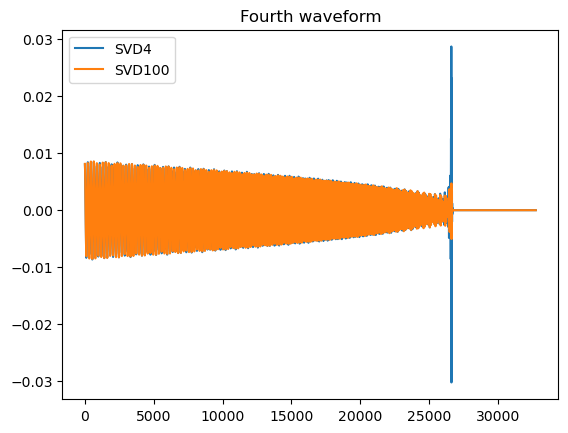

In [40]:
# Zoomed in
plt.plot(np.arange(len(U_4.T[3])), U_4.T[3], label='SVD4')
plt.plot(np.arange(len(U_4.T[3])), -U.T[3], label='SVD100')
plt.legend()
plt.title('Fourth waveform')
plt.xlim(0,5000)
plt.show()

# Zoomed out
plt.plot(np.arange(len(U_4.T[3])), U_4.T[3], label='SVD4')
plt.plot(np.arange(len(U_4.T[3])), -U.T[3], label='SVD100')
plt.legend()
plt.title('Fourth waveform')
plt.show()

Seems initially here that h4 might be described well by just four waveform components, however zooming back out reveals that this breaks down at the merger, with a much larger spike in SVD4 which is not present in SVD100.

We would now like to solve for U to test our predictions for what the coefficients of the training waveforms should be for each set. On plots of coefficients, will multiply coefficients by number of waveform components in order to normalise.

In [41]:
# Solve for U
Vinv_S_2 = np.matmul(Vh_2.T.conj(), np.diag(1/S_2))
Vinv_S_3 = np.matmul(Vh_3.T.conj(), np.diag(1/S_3))
Vinv_S_4 = np.matmul(Vh_4.T.conj(), np.diag(1/S_4))

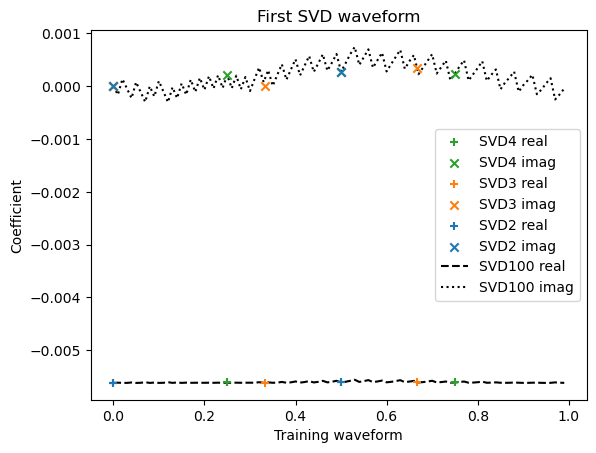

In [42]:
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[0]), endpoint=False), np.real(Vinv_S_4.T[0])*len(Vinv_S_4.T[0]), marker='+', c='C2', label='SVD4 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[0]), endpoint=False), np.imag(Vinv_S_4.T[0])*len(Vinv_S_4.T[0]), marker='x', c='C2', label='SVD4 imag')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[0]), endpoint=False), np.real(Vinv_S_3.T[0])*len(Vinv_S_3.T[0]), marker='+', c='C1', label='SVD3 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[0]), endpoint=False), np.imag(Vinv_S_3.T[0])*len(Vinv_S_3.T[0]), marker='x', c='C1', label='SVD3 imag')
plt.scatter(np.linspace(0, 1, len(Vinv_S_2.T[0]), endpoint=False), np.real(Vinv_S_2.T[0])*len(Vinv_S_2.T[0]), marker='+', c='C0', label='SVD2 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_2.T[0]), endpoint=False), np.imag(Vinv_S_2.T[0])*len(Vinv_S_2.T[0]), marker='x', c='C0', label='SVD2 imag')
plt.plot(np.linspace(0, 1, len(Vinv_S.T[0]), endpoint=False), np.real(Vinv_S.T[0])*len(Vinv_S.T[0]), c='k', ls='dashed', label='SVD100 real', zorder=-1)
plt.plot(np.linspace(0, 1, len(Vinv_S.T[0]), endpoint=False), np.imag(Vinv_S.T[0])*len(Vinv_S.T[0]), c='k', ls='dotted', label='SVD100 imag', zorder=-1)
plt.title('First SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()

As expected, simple averages are taken here just like for SVD100. Note that the first and third green SVD4 markers are hidden behind the blue SVD2 markers.

In [43]:
scaling = 1/Vinv_S_3.T[1][0]
print(Vinv_S_3.T[1]*scaling)
print(np.roots([1,0,0,-1]))

[ 1.        +0.j         -0.49230425+0.89635718j -0.56287923-0.8631815j ]
[-0.5+0.8660254j -0.5-0.8660254j  1. +0.j       ]


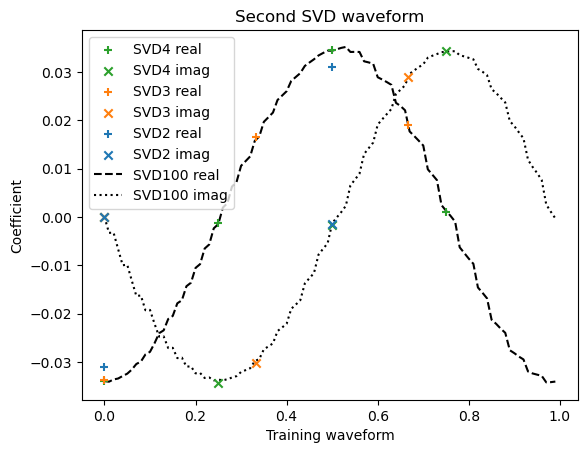

In [44]:
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[1]), endpoint=False), np.real(Vinv_S_4.T[1])*len(Vinv_S_4.T[1]), marker='+', c='C2', label='SVD4 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[1]), endpoint=False), np.imag(Vinv_S_4.T[1])*len(Vinv_S_4.T[1]), marker='x', c='C2', label='SVD4 imag')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[1]), endpoint=False), np.real(Vinv_S_3.T[1])*len(Vinv_S_3.T[1]), marker='+', c='C1', label='SVD3 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[1]), endpoint=False), np.imag(Vinv_S_3.T[1])*len(Vinv_S_3.T[1]), marker='x', c='C1', label='SVD3 imag')
plt.scatter(np.linspace(0, 1, len(Vinv_S_2.T[1]), endpoint=False), np.real(Vinv_S_2.T[1])*len(Vinv_S_2.T[1]), marker='+', c='C0', label='SVD2 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_2.T[1]), endpoint=False), np.imag(Vinv_S_2.T[1])*len(Vinv_S_2.T[1]), marker='x', c='C0', label='SVD2 imag')
plt.plot(np.linspace(0, 1, len(Vinv_S.T[1]), endpoint=False), -np.real(Vinv_S.T[1])*len(Vinv_S.T[1]), c='k', ls='dashed', label='SVD100 real', zorder=-1)
plt.plot(np.linspace(0, 1, len(Vinv_S.T[1]), endpoint=False), -np.imag(Vinv_S.T[1])*len(Vinv_S.T[1]), c='k', ls='dotted', label='SVD100 imag', zorder=-1)
plt.title('Second SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()

Again matches here! Note had to multiply SVD100 by -1 here, but again this is arbitrary and does not matter.

Will now test for completeness the third and fourth waveforms.

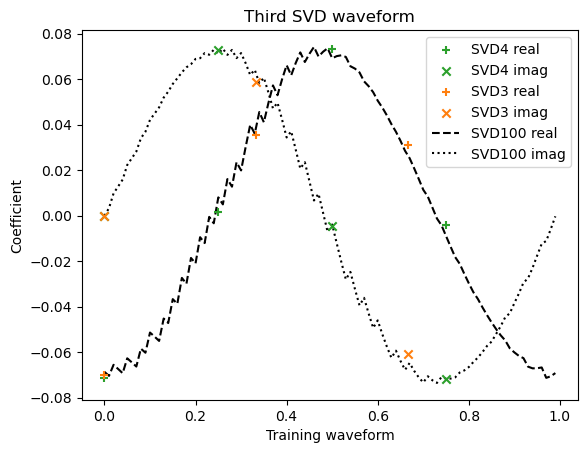

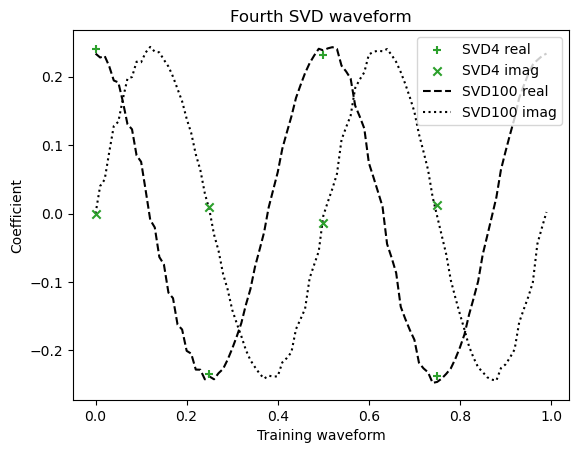

In [45]:
# Third
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[2]), endpoint=False), np.real(Vinv_S_4.T[2])*len(Vinv_S_4.T[2]), marker='+', c='C2', label='SVD4 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[2]), endpoint=False), np.imag(Vinv_S_4.T[2])*len(Vinv_S_4.T[2]), marker='x', c='C2', label='SVD4 imag')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[2]), endpoint=False), -np.real(Vinv_S_3.T[2])*len(Vinv_S_3.T[2]), marker='+', c='C1', label='SVD3 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_3.T[2]), endpoint=False), -np.imag(Vinv_S_3.T[2])*len(Vinv_S_3.T[2]), marker='x', c='C1', label='SVD3 imag')
plt.plot(np.linspace(0, 1, len(Vinv_S.T[2]), endpoint=False), np.real(Vinv_S.T[2])*len(Vinv_S.T[2]), c='k', ls='dashed', label='SVD100 real', zorder=-1)
plt.plot(np.linspace(0, 1, len(Vinv_S.T[2]), endpoint=False), np.imag(Vinv_S.T[2])*len(Vinv_S.T[2]), c='k', ls='dotted', label='SVD100 imag', zorder=-1)
plt.title('Third SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()
plt.show()

# Fourth
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[3]), endpoint=False), np.real(Vinv_S_4.T[3])*len(Vinv_S_4.T[3]), marker='+', c='C2', label='SVD4 real')
plt.scatter(np.linspace(0, 1, len(Vinv_S_4.T[3]), endpoint=False), np.imag(Vinv_S_4.T[3])*len(Vinv_S_4.T[3]), marker='x', c='C2', label='SVD4 imag')
plt.plot(np.linspace(0, 1, len(Vinv_S.T[3]), endpoint=False), -np.real(Vinv_S.T[3])*len(Vinv_S.T[3]), c='k', ls='dashed', label='SVD100 real', zorder=-1)
plt.plot(np.linspace(0, 1, len(Vinv_S.T[3]), endpoint=False), -np.imag(Vinv_S.T[3])*len(Vinv_S.T[3]), c='k', ls='dotted', label='SVD100 imag', zorder=-1)
plt.title('Fourth SVD waveform')
plt.xlabel('Training waveform')
plt.ylabel('Coefficient')
plt.legend()
plt.show()

Again here the coefficients  appear in a predictable fashion.

Will examine the relative importances given by the S matrices.

In [46]:
wf_names = ['First', 'Second', 'Third', 'Fourth', 'Fifth']

# SVD2
rel_imports_2 = []
for i in range(2):
    rel_imports_2.append(S_2[i]**2/np.sum(S_2**2))
    print('{} SVD2 waveform contains {:.2f}% of the total information.'.format(wf_names[i], rel_imports_2[i]*100))
print('\n')

# SVD3
rel_imports_3 = []
for i in range(3):
    rel_imports_3.append(S_3[i]**2/np.sum(S_3**2))
    print('{} SVD3 waveform contains {:.2f}% of the total information.'.format(wf_names[i], rel_imports_3[i]*100))
print('\n')

# SVD4
rel_imports_4 = []
for i in range(4):
    rel_imports_4.append(S_4[i]**2/np.sum(S_4**2))
    print('{} SVD4 waveform contains {:.2f}% of the total information.'.format(wf_names[i], rel_imports_4[i]*100))
print('\n')

# SVD100
rel_imports_100 = []
for i in range(5):
    rel_imports_100.append(S[i]**2/np.sum(S**2))
    print('{} SVD100 waveform contains {:.2f}% of the total information.'.format(wf_names[i], rel_imports_100[i]*100))

First SVD2 waveform contains 96.83% of the total information.
Second SVD2 waveform contains 3.17% of the total information.


First SVD3 waveform contains 96.76% of the total information.
Second SVD3 waveform contains 2.60% of the total information.
Third SVD3 waveform contains 0.64% of the total information.


First SVD4 waveform contains 96.77% of the total information.
Second SVD4 waveform contains 2.59% of the total information.
Third SVD4 waveform contains 0.58% of the total information.
Fourth SVD4 waveform contains 0.05% of the total information.


First SVD100 waveform contains 96.73% of the total information.
Second SVD100 waveform contains 2.60% of the total information.
Third SVD100 waveform contains 0.59% of the total information.
Fourth SVD100 waveform contains 0.05% of the total information.
Fifth SVD100 waveform contains 0.02% of the total information.


This is consistent with expectations.

Finally will match against SVD100 waveforms to quantify how good of an approximation each training waveform set is.

In [47]:
# Convert SVD100 to timeseries objects
h_fids = []
for i in range(4):
    h_fids.append(timeseries.TimeSeries(U.T[i], 1/4096, epoch=0))

# Convert SVD2 to timeseries objects
h_2s = []
for i in range(2):
    h_2s.append(timeseries.TimeSeries(U_2.T[i], 1/4096, epoch=0))

# Convert SVD3 to timeseries objects
h_3s = []
for i in range(3):
    h_3s.append(timeseries.TimeSeries(U_3.T[i], 1/4096, epoch=0))

# Convert SVD4 to timeseries objects
h_4s = []
for i in range(4):
    h_4s.append(timeseries.TimeSeries(U_4.T[i], 1/4096, epoch=0))

In [48]:
# SVD2
matches_2 = []
for i in range(2):
    matches_2.append(match_wfs(h_fids[i], h_2s[i], 10, True))
    print('{} SVD2 waveform match with SVD100: {:.4f}'.format(wf_names[i], matches_2[i]))
print('\n')

# SVD3
matches_3 = []
for i in range(3):
    matches_3.append(match_wfs(h_fids[i], h_3s[i], 10, True))
    print('{} SVD3 waveform match with SVD100: {:.4f}'.format(wf_names[i], matches_3[i]))
print('\n')

# SVD4
matches_4 = []
for i in range(4):
    matches_4.append(match_wfs(h_fids[i], h_4s[i], 10, True))
    print('{} SVD4 waveform match with SVD100: {:.4f}'.format(wf_names[i], matches_4[i]))

First SVD2 waveform match with SVD100: 0.9998
Second SVD2 waveform match with SVD100: 0.9605


First SVD3 waveform match with SVD100: 1.0000
Second SVD3 waveform match with SVD100: 0.9876
Third SVD3 waveform match with SVD100: 0.8773


First SVD4 waveform match with SVD100: 1.0000
Second SVD4 waveform match with SVD100: 0.9889
Third SVD4 waveform match with SVD100: 0.9749
Fourth SVD4 waveform match with SVD100: 0.8377


Just like with earlier plots, we see that the n+1th waveform component is crucial to being able to accurately describe $h_n$.

# Eigenvector order prediction

Predict that coefficients of n waveform components are eigenvectors of circulant matrices: $(1, \omega^j, \ldots, \omega^{(n-1)j})$ for $j=0,\ldots,n-1$. Also predict that the order in which these eigennvectors are used to create $h_1,...,h_n$ is ascending, with the exception of $n-j$, which always immediately follows $j$. 

The following table shows the previous SVDs, which follow this pattern, as well as the predicted order of eigenvectors for SVD5 and SVD6, which we calculate and check in this section.

| n | j           | SVD       |
|---|-------------|-----------|
| 2 | 0,1         | Confirmed |
| 3 | 0,1,2       | Confirmed |
| 4 | 0,1,3,2     | Confirmed |
| 5 | 0,1,4,2,3   | Predicted |
| 6 | 0,1,5,2,4,3 | Predicted |,4,3 |

In [49]:
# Generate training waveform sets
training_wfs_5 = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 5, 4096, 'TEOBResumS')
training_wfs_6 = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 6, 4096, 'TEOBResumS')

6 done out of 6.

In [50]:
# Perform SVD on five training waveforms
start = time.time()
X = np.array(training_wfs_5).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_5, S_5, Vh_5 = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

# Perform SVD on six training waveforms
start = time.time()
X = np.array(training_wfs_6).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_6, S_6, Vh_6 = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 121.83055686950684 seconds
Time taken: 124.36946082115173 seconds


In [51]:
# Solve for U
Vinv_S_5 = np.matmul(Vh_5.T.conj(), np.diag(1/S_5))
Vinv_S_6 = np.matmul(Vh_6.T.conj(), np.diag(1/S_6))

Explicit form of predicted eigenvectors for n=5:

| $h_i$ | j | eigenvector                                      |
|-------|---|--------------------------------------------------|
| $h_1$ | 0 | (1,1,1,1,1)                                      |
| $h_2$ | 1 | (1,$\omega$, $\omega^2$, $\omega^3$, $\omega^4$) |
| $h_3$ | 4 | (1,$\omega^4$, $\omega^3$, $\omega^2$, $\omega$) |
| $h_4$ | 2 | (1,$\omega^2$, $\omega^4$, $\omega$, $\omega^3$) |
| $h_5$ | 3 | (1,$\omega^3$, $\omega$, $\omega^4$, $\omega^2$) |ga$) |ega$ |

Note: Some SVD results may differ by a minus sign - this is arbitrary and can be ignored, so a minus sign is hardcoded in to ensure consistency.

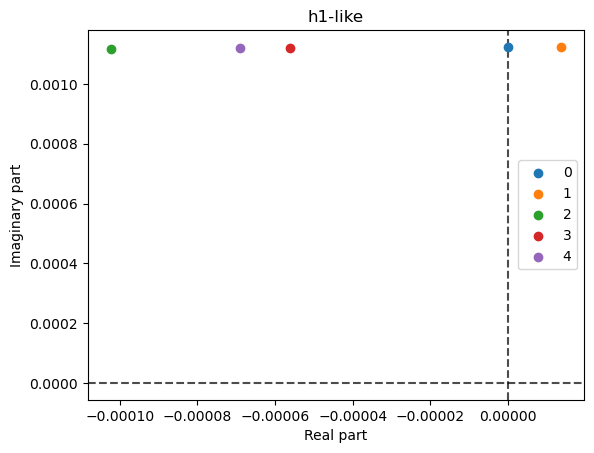

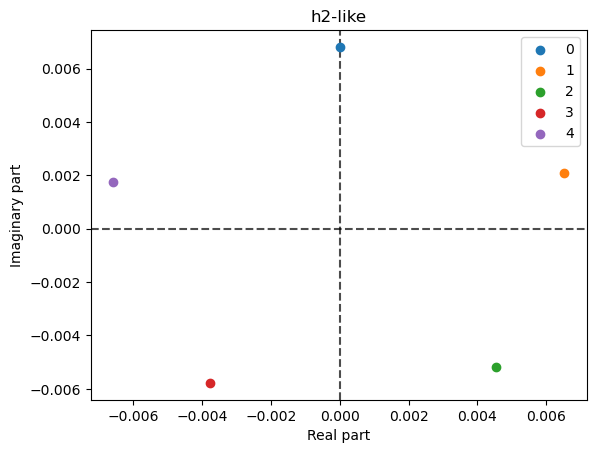

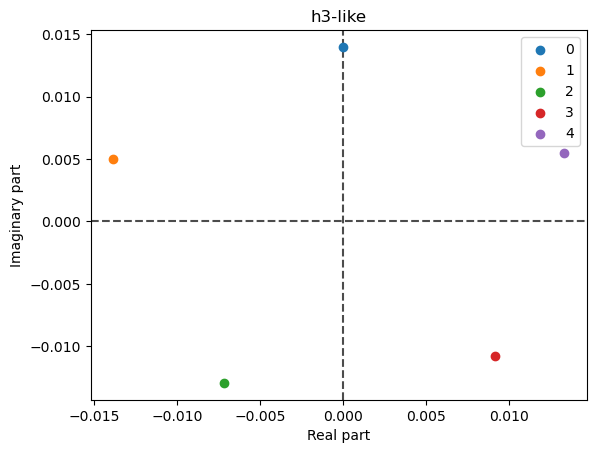

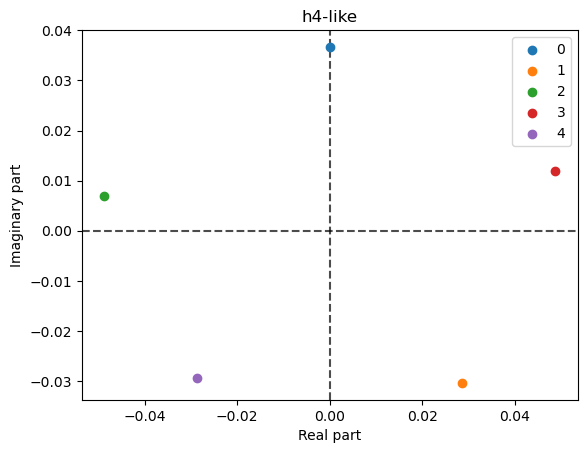

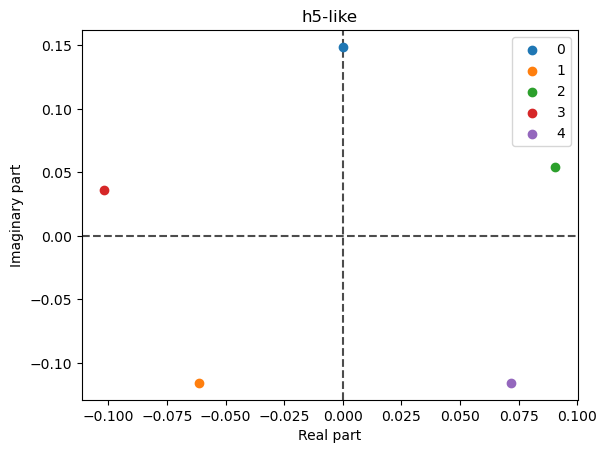

In [52]:
flip_sign = np.array([-1,-1,-1,1,-1])
for i in range(5):
    for j in range(5):
        plt.scatter(np.imag(flip_sign[i]*Vinv_S_5.T[i][j]), np.real(flip_sign[i]*Vinv_S_5.T[i][j]), label=str(j))
    plt.axvline(0, ls='dashed', c='k', zorder=-1, alpha=0.7)
    plt.axhline(0, ls='dashed', c='k', zorder=-1, alpha=0.7)
    plt.legend()
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'h{i+1}-like')
    plt.show()

This matches predictions exactly! Let's make similar plots for SVD6 now, keeping the same prediction:

| $h_i$ | j | eigenvector                                                  |
|-------|---|--------------------------------------------------------------|
| $h_1$ | 0 | (1,1,1,1,1)                                                  |
| $h_2$ | 1 | (1,$\omega$, $\omega^2$, $\omega^3$, $\omega^4$, $\omega^5$) |
| $h_3$ | 5 | (1,$\omega^5$, $\omega^4$, $\omega^3$, $\omega^2$, $\omega$) |
| $h_4$ | 2 | (1,$\omega^2$, $\omega^4$, 1, $\omega^2$, $\omega^4$)        |
| $h_5$ | 4 | (1,$\omega^4$, $\omega^2$, 1, $\omega^4$, $\omega^2$)        |
| $h_6$ | 3 | (1,$\omega^3$, 1, $\omega^3$, 1, $\omega^3$)                 |

Note that $\omega^3$ here is equal to -1.

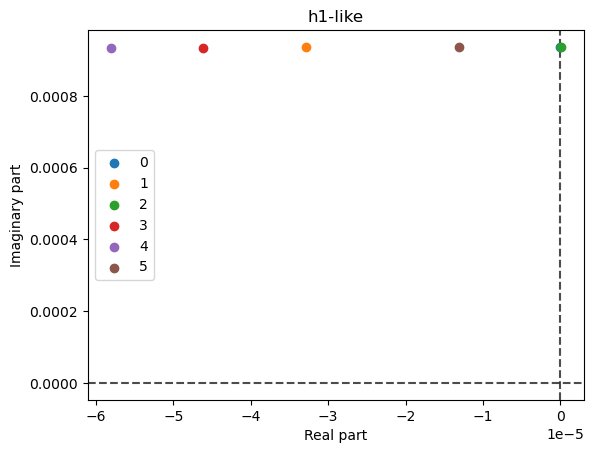

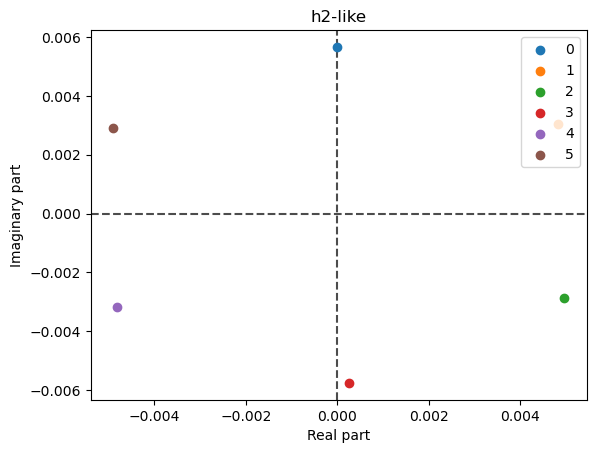

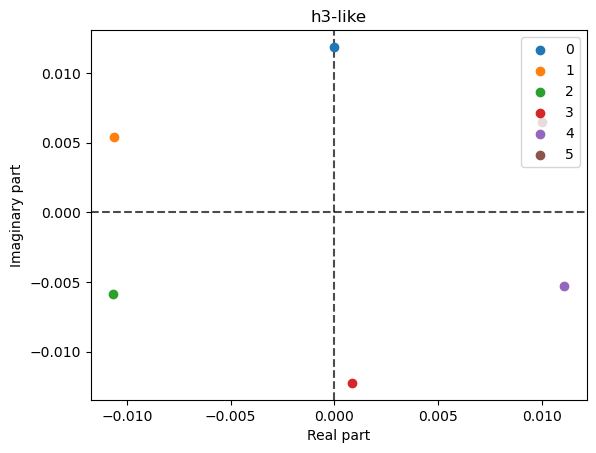

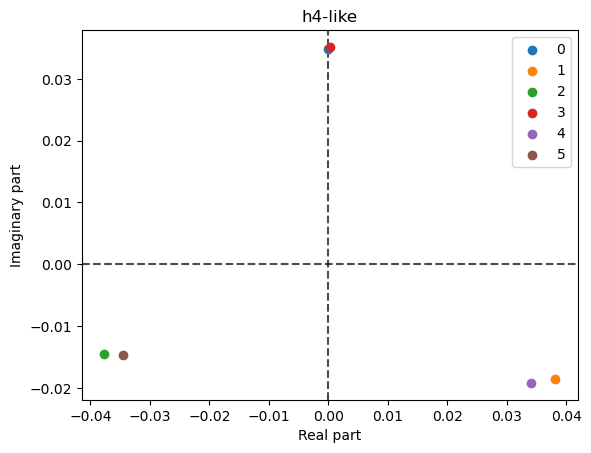

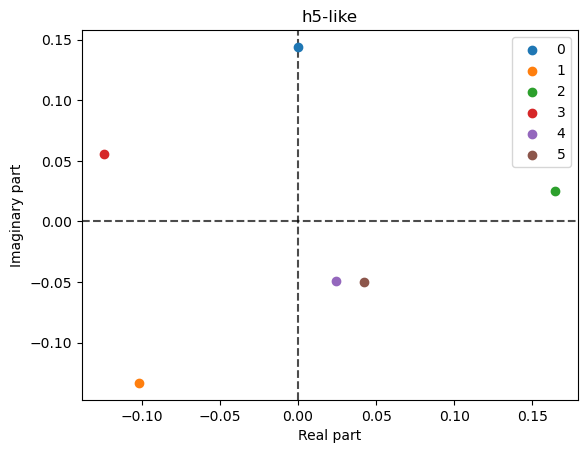

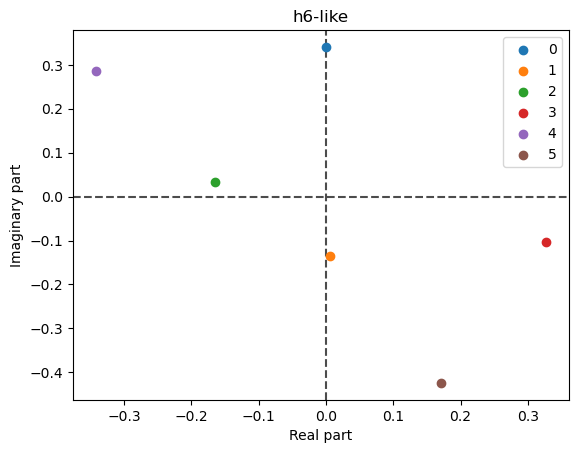

In [53]:
flip_sign = np.array([-1,-1,1,1,1,-1])
for i in range(6):
    for j in range(6):
        plt.scatter(np.imag(flip_sign[i]*Vinv_S_6.T[i][j]), np.real(flip_sign[i]*Vinv_S_6.T[i][j]), label=str(j))
    plt.axvline(0, ls='dashed', c='k', zorder=-1, alpha=0.7)
    plt.axhline(0, ls='dashed', c='k', zorder=-1, alpha=0.7)
    plt.legend()
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'h{i+1}-like')
    plt.show()

Appears SVD has failed to recover these eigenvectors for h5 and h6, which is perhaps not too surprising as the information content of these waveforms is extremely low, and this is also where the SVD100 starts to break down. The pattern is confirmed here however up to h4, so I am pretty confident in saying this is now well understood.

# Varying phase

Will create 200 training waveforms at 20 different true anomalies, and 10 different phases.

In [69]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs_phase(f_low, e, M, q, n, m, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            for j in range(m):
                h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle+j*np.pi/m)
                h = trim_wf(h, training_wfs[0])
                h.resize(ceiltwo(len(h)))   
                training_wfs.append(h)
                print(f'\r{len(training_wfs)} done out of {n*m}.', end='') 
        else:
            h.resize(ceiltwo(len(h)))   
            training_wfs.append(h)
            print(f'\r{len(training_wfs)} done out of {n*m}.', end='')
            for j in range(1,m):
                h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=j*np.pi/m)
                h = trim_wf(h, training_wfs[0])
                h.resize(ceiltwo(len(h)))   
                training_wfs.append(h)
                print(f'\r{len(training_wfs)} done out of {n*m}.', end='')
                
    return training_wfs

In [76]:
training_wfs_phase = gen_training_wfs_phase(10, 0.1, chirp2total(24, 2), 2, 20, 10, 4096, 'TEOBResumS')

200 done out of 200.

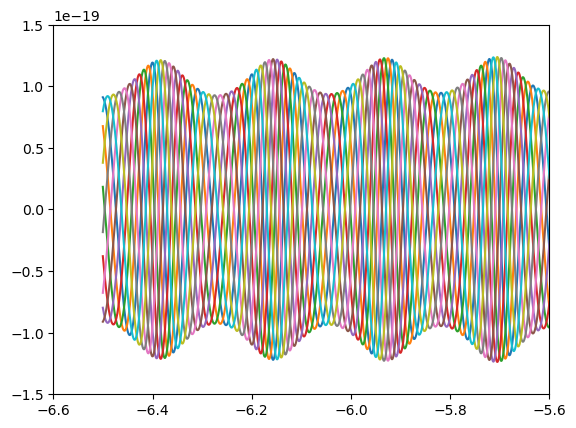

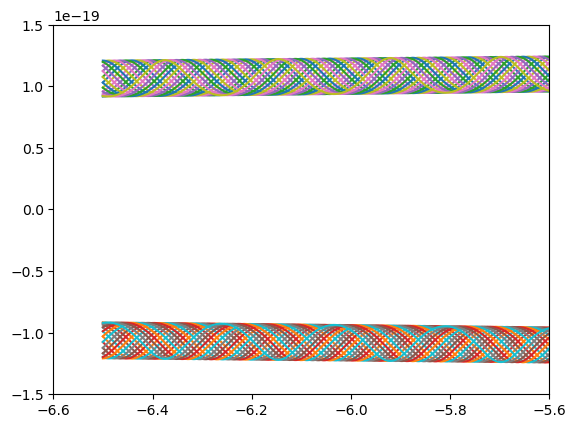

In [80]:
for wf in training_wfs_phase[:10]:
    plt.plot(wf.sample_times, wf)
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

for wf in training_wfs_phase[::10]:
    plt.plot(wf.sample_times, np.sqrt(wf.real()**2+wf.imag()**2))
    plt.plot(wf.sample_times, -np.sqrt(wf.real()**2+wf.imag()**2))
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

In [81]:
# Convert training wf data to np array in right shape/form and calc svd
start = time.time()
X = np.array(training_wfs_phase).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U_p, S_p, Vh_p = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 686.2186453342438 seconds


Now let's take a look at relative importances:

In [82]:
rel_imports = []
for i in range(10):
    rel_imports.append(S_p[i]**2/np.sum(S_p**2))
    print('Component {} contains {:.5f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Components 0 and 1 combined contain {:.5f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Component 0 contains 96.74283% of the total information.
Component 1 contains 2.59707% of the total information.
Component 2 contains 0.58745% of the total information.
Component 3 contains 0.05400% of the total information.
Component 4 contains 0.01752% of the total information.
Component 5 contains 0.00093% of the total information.
Component 6 contains 0.00012% of the total information.
Component 7 contains 0.00005% of the total information.
Component 8 contains 0.00002% of the total information.
Component 9 contains 0.00001% of the total information.


Components 0 and 1 combined contain 99.33990% of the total information.


We find almost exactly the same amount of informations in each component. We can therefore conclude that we can gain no additional information by using waveforms at differing phases.